In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.2 MB/s eta 0:00:00


In [ ]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 8.4 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from catboost import CatBoostRegressor, Pool, cv
from catboost import MetricVisualizer

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from scipy.stats import boxcox
from os import listdir

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import shap
shap.initjs()

Read the data

In [5]:
data = pd.read_csv("/content/data.csv", encoding="ISO-8859-1", dtype={'CustomerID': str})
data.shape

(541909, 8)

The data has 541909 entries and 8 variables.

## 2. Get familiar with the data <a class="anchor" id="intro"></a>

In [ ]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


We can see that the datafile has information given for **each single transaction**.
Take a look at the InvoiceNo and the CustomerID of the first entries. Here we can see that **one customer with ID 17850 of the United Kingdom made a single order that has the InvoideNo 536365**.
The customer ordered **several products with different stockcodes, descriptions, unit prices and quantities**. In addition we can see that the InvoiceDate was the same for these products.

## 3.Data Exploration <a class="anchor" id="feeling"></a>

In [ ]:
missing_percentage = data.isnull().sum() / data.shape[0] * 100
missing_percentage

,0
InvoiceNo,0.000000
StockCode,0.000000
Description,0.268311
Quantity,0.000000
InvoiceDate,0.000000
UnitPrice,0.000000
CustomerID,24.926694
Country,0.000000


Almost 25 % of the customers are unknown! That's very strange.
In addition we have 0.2 % of missing descriptions. This looks dirty.

Let's gain a further impression by considering some examples.

**Missing descriptions**

In [ ]:
data[data.Description.isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,12/1/2010 14:32,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,12/1/2010 14:34,0.0,NaN,United Kingdom


How often do we miss the customer as well?

In [ ]:
data[data.Description.isnull()].CustomerID.isnull().value_counts()

,count
CustomerID,
True,1454


In **cases of missing descriptions we always miss the customer and the unit price as well**.
Why does the retailer records such kind of entries without a further description?
It seems that there is no sophisticated procedure how to deal with and record such kind of transactions.
This is already a hint that **we could expect strange entries in our data and that it can be difficult to detect them**!

**Missing Customer IDs**

In [ ]:
data[data.CustomerID.isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


In [ ]:
data.loc[data.CustomerID.isnull(), ["UnitPrice", "Quantity"]].describe()

,UnitPrice,Quantity
count,135080.000000,135080.000000
mean,8.076577,1.995573
std,151.900816,66.696153
min,-11062.060000,-9600.000000
25%,1.630000,1.000000
50%,3.290000,1.000000
75%,5.450000,3.000000
max,17836.460000,5568.000000


That's bad as well. **The price and the quantities of entries without a customer ID can show extreme outliers**.
As we might want to create features later on that are based on historical prices and sold quantities, this is very disruptive.
Our first **advice for the retailer is to setup strategies for transactions that are somehow faulty or special**.
And the question remains: Why is it possible for a transaction to be without a customer ID. Perhaps you can purchase as a quest but then it would of a good and clean style to plugin a special ID that indicates that this one is a guest.
Ok, next one: Do we have hidden nan-values in Descriptions? To find it out, let's create a new feature that hold descriptions in lowercase:

**Hidden missing descriptions**

Can we find "nan"-Strings?

In [ ]:
data.loc[data.Description.isnull()==False, "lowercase_descriptions"] = data.loc[
    data.Description.isnull()==False,"Description"
].apply(lambda l: l.lower())

data.lowercase_descriptions.dropna().apply(
    lambda l: np.where("nan" in l, True, False)
).value_counts()

,count
lowercase_descriptions,
False,539724
True,731


Can we find empty ""-strings?

In [ ]:
data.lowercase_descriptions.dropna().apply(
    lambda l: np.where("" == l, True, False)
).value_counts()

,count
lowercase_descriptions,
False,540455


We found **additional, hidden nan-values that show a string "nan" instead of a nan-value**. Let's transform them to NaN:

In [ ]:
data.loc[data.lowercase_descriptions.isnull()==False, "lowercase_descriptions"] = data.loc[
    data.lowercase_descriptions.isnull()==False, "lowercase_descriptions"
].apply(lambda l: np.where("nan" in l, None, l))

As we don't know why customers or descriptions are missing and we have seen strange outliers in quantities and prices as well as zero-prices, **let's play safe and drop all of these occurences**.

Just to be sure: Is there a missing value left?

In [ ]:
data.isnull().sum().sum()

138719

### The Time period <a class="anchor" id="timeperiod"></a>

How long is the period in days?

In [ ]:
data["InvoiceDate"] = pd.to_datetime(data.InvoiceDate, cache=True)

data.InvoiceDate.max() - data.InvoiceDate.min()

Timedelta('373 days 04:24:00')

In [ ]:
print("Datafile starts with timepoint {}".format(data.InvoiceDate.min()))
print("Datafile ends with timepoint {}".format(data.InvoiceDate.max()))

Datafile starts with timepoint 2010-12-01 08:26:00
Datafile ends with timepoint 2011-12-09 12:50:00


### The invoice number <a class="anchor" id="invoiceno"></a>

In [ ]:
data.InvoiceNo.nunique()

25900

In the data description we can find that a cancelled transactions starts with a "C" in front of it. Let's create a feature to easily filter out these cases:

In [ ]:
data["IsCancelled"]=np.where(data.InvoiceNo.apply(lambda l: l[0]=="C"), True, False)
data.IsCancelled.value_counts() / data.shape[0] * 100

,count
IsCancelled,
False,98.286059
True,1.713941


2,2 % of all entries are cancellations.  

In [ ]:
data.loc[data.IsCancelled==True].describe()

,Quantity,InvoiceDate,UnitPrice
count,9288.000000,9288,9288.000000
mean,-29.885228,2011-06-26 03:42:05.943152640,48.393661
min,-80995.000000,2010-12-01 09:41:00,0.010000
25%,-6.000000,2011-03-21 16:15:00,1.450000
50%,-2.000000,2011-07-07 17:33:30,2.950000
75%,-1.000000,2011-10-06 20:36:00,5.950000
max,-1.000000,2011-12-09 11:58:00,38970.000000
std,1145.786965,NaN,666.600430


**All cancellations have negative quantites but positive, non-zero unit prices**. Given this data we are not easily able to understand why a customer made a return and it's very difficult to predict such cases as there could be several, hidden reasons why a cancellation was done. Let's drop them:

In [ ]:
data = data.loc[data.IsCancelled==False].copy()
data = data.drop("IsCancelled", axis=1)

### Stockcodes <a class="anchor" id="stockcodes"></a>

How many unique stockcodes do we have?

In [ ]:
data.StockCode.nunique()

4059

Which indexes are most common?

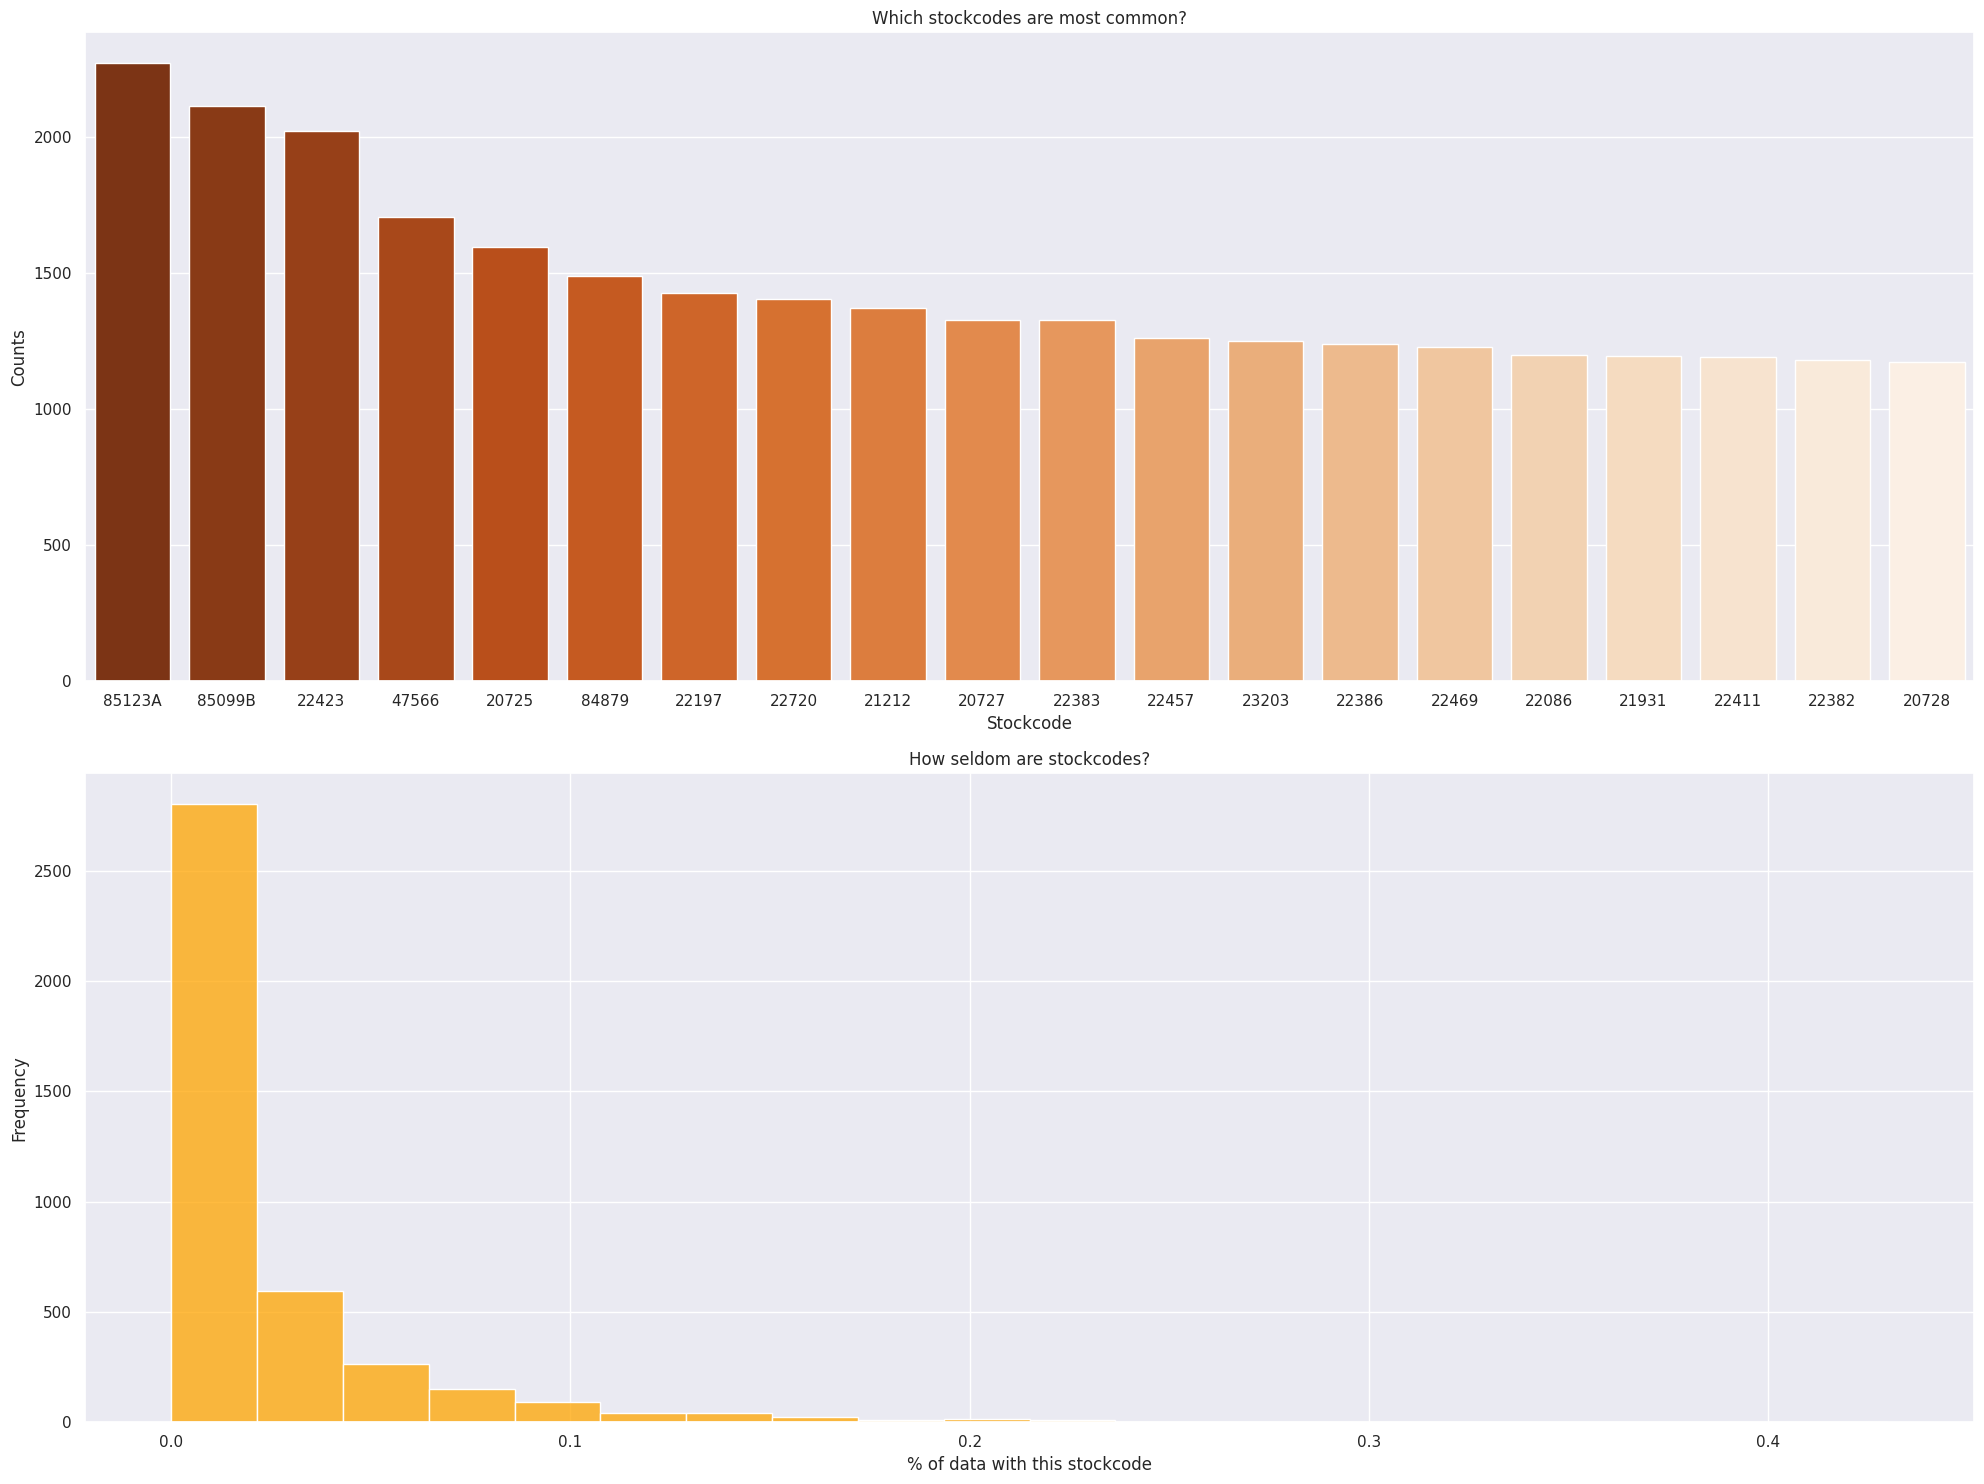

In [ ]:
stockcode_counts = data.StockCode.value_counts().sort_values(ascending=False)

fig, ax = plt.subplots(2, 1, figsize=(20, 15))

# Barplot for the most common stockcodes
sns.barplot(x=stockcode_counts.iloc[0:20].index,
            y=stockcode_counts.iloc[0:20].values,
            ax=ax[0], palette="Oranges_r")
ax[0].set_ylabel("Counts")
ax[0].set_xlabel("Stockcode")
ax[0].set_title("Which stockcodes are most common?")

# Histogram for the distribution of stockcodes by percentage
sns.histplot(np.round(stockcode_counts/data.shape[0]*100, 2),
             bins=20,
             ax=ax[1], color="Orange", kde=False)
ax[1].set_title("How seldom are stockcodes?")
ax[1].set_xlabel("% of data with this stockcode")
ax[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


* Do you the the **POST** in the most common stockcode counts?! **That's a strange one!** Hence we could expect strange occurences not only in the descriptions and customerIDs but also in the stockcode. OHOHOH! It's code is shorter than the others as well as not numeric.
* Most stockcodes are very seldom. This indicates that the **retailer sells many different products** and that there is no strong secialization of a specific stockcode. Nevertheless we have to be careful as this must not mean that the retailer is not specialized given a specific product type. The stockcode could be a very detailed indicator that does not yield information of the type, for example water bottles may have very different variants in color, name and shapes but they are all water bottles.  

Let's count the number of numeric chars in and the length of the stockcode:

In [5]:
def count_numeric_chars(l):
    return sum(1 for c in l if c.isdigit())

data["StockCodeLength"] = data.StockCode.apply(lambda l: len(l))
data["nNumericStockCode"] = data.StockCode.apply(lambda l: count_numeric_chars(l))

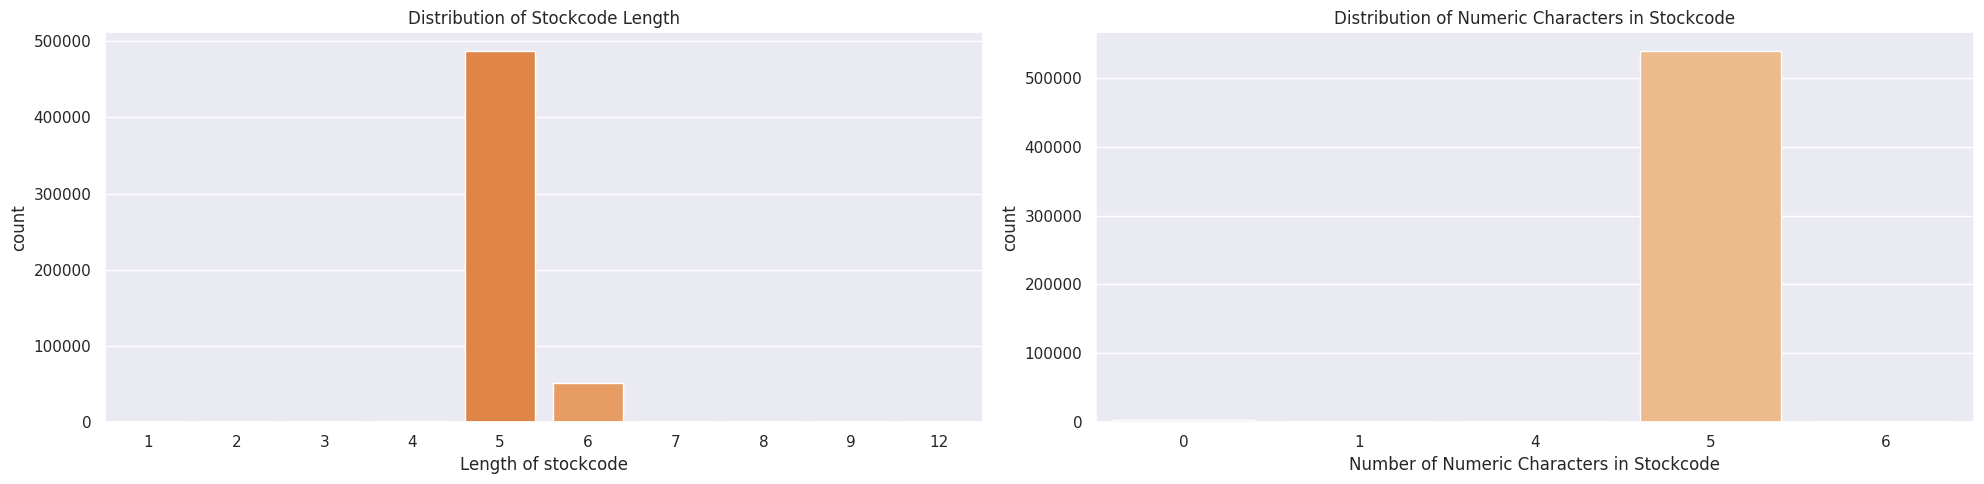

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# Count plot for the length of stock codes
sns.countplot(x=data["StockCodeLength"], palette="Oranges_r", ax=ax[0])
ax[0].set_xlabel("Length of stockcode")
ax[0].set_title("Distribution of Stockcode Length")

# Count plot for the number of numeric characters in the stock codes
sns.countplot(x=data["nNumericStockCode"], palette="Oranges_r", ax=ax[1])
ax[1].set_xlabel("Number of Numeric Characters in Stockcode")
ax[1].set_title("Distribution of Numeric Characters in Stockcode")

plt.tight_layout()
plt.show()


Even though the majority of samples has a stockcode that consists of 5 numeric chars, we can see that there are other occurences as well. The length can vary between 1 and 12 and there are stockcodes with no numeric chars at all!

In [8]:
# Ensure 'lowercase_descriptions' column exists
if 'lowercase_descriptions' in data.columns:
    # Filter rows where nNumericStockCode is less than 5
    filtered_data = data.loc[data.nNumericStockCode < 5]

    # Get the value counts of 'lowercase_descriptions'
    value_counts = filtered_data['lowercase_descriptions'].value_counts()
    print(value_counts)
else:
    print("Column 'lowercase_descriptions' does not exist in the DataFrame.")


Column 'lowercase_descriptions' does not exist in the DataFrame.


In [9]:
data = data.drop(["nNumericStockCode", "StockCodeLength"], axis=1)

### Descriptions <a class="anchor" id="descriptions"></a>

How many unique descriptions do we have?

In [10]:
data.Description.nunique()

4223

And which are most common?

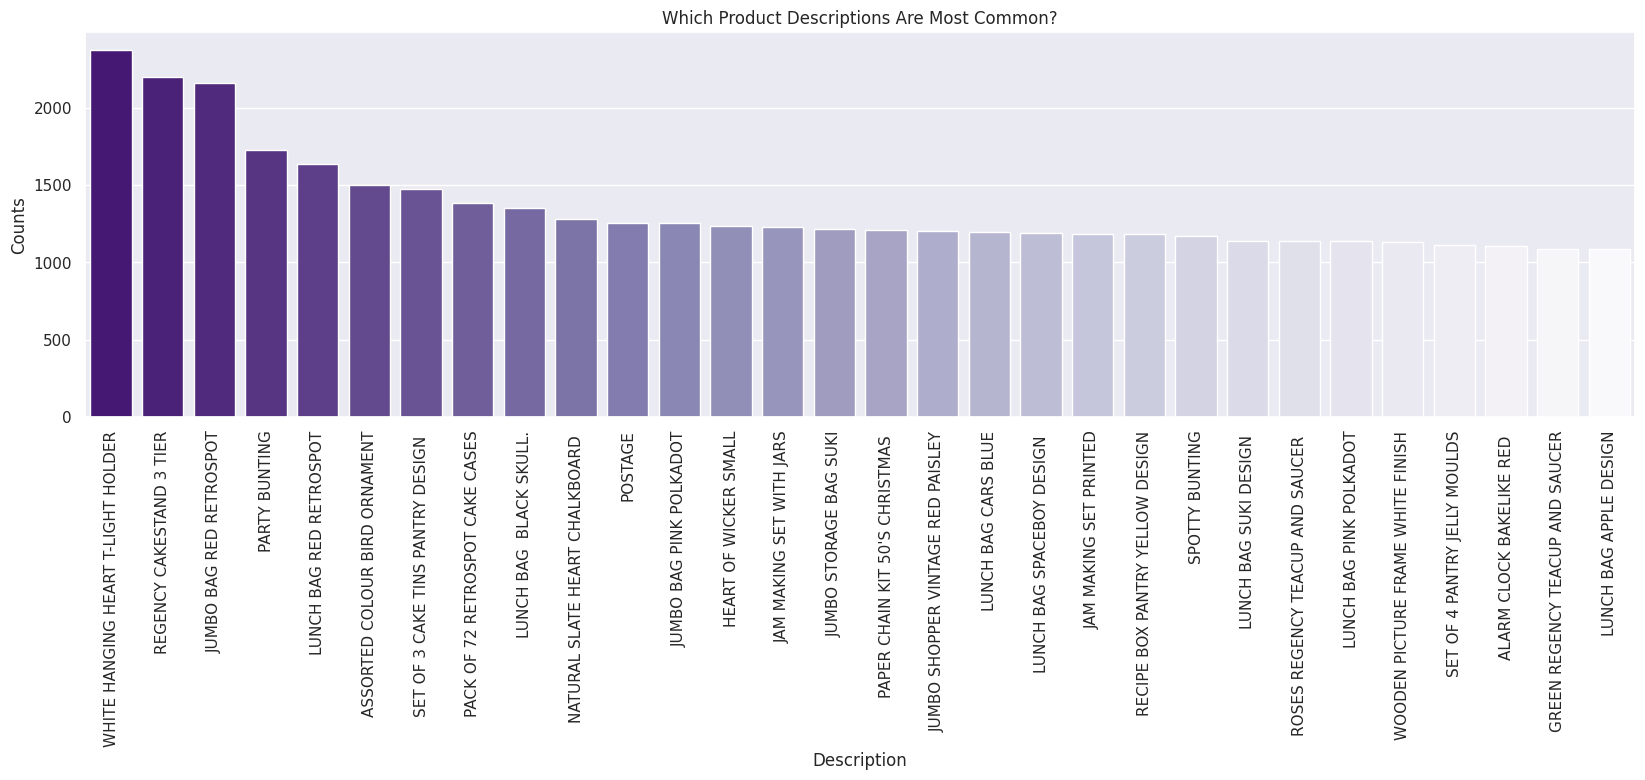

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'Description' column exists
if 'Description' in data.columns:
    # Get the top 30 most common product descriptions
    description_counts = data.Description.value_counts().sort_values(ascending=False).iloc[0:30]

    plt.figure(figsize=(20, 5))

    # Create a bar plot
    sns.barplot(x=description_counts.index, y=description_counts.values, palette="Purples_r")

    plt.ylabel("Counts")
    plt.title("Which Product Descriptions Are Most Common?")
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

    plt.show()
else:
    print("Column 'Description' does not exist in the DataFrame.")


Ok, we can see that **some descriptions correspond to a similar product type**. Do you see the multiple occurences of lunch bags? We often have **color information about the product** as well. Furthermore the most common descriptions seem to confirm that **the retailer sells various different kinds of products**. All descriptions seem to consist of **uppercase chars**. Ok, now let's do some addtional analysis on the descriptions by counting the length and the number of lowercase chars.

In [13]:
def count_lower_chars(l):
    return sum(1 for c in l if c.islower())

In [6]:
def count_lower_chars(text):
    """
    Counts the number of lowercase characters in the given string.
    """
    return sum(1 for c in text if c.islower())

# Ensure 'Description' column is in string format to avoid issues
data['Description'] = data['Description'].astype(str)

# Calculate the length of each product description
data['DescriptionLength'] = data['Description'].apply(lambda l: len(l))

# Calculate the number of lowercase characters in each product description
data['LowCharsInDescription'] = data['Description'].apply(count_lower_chars)


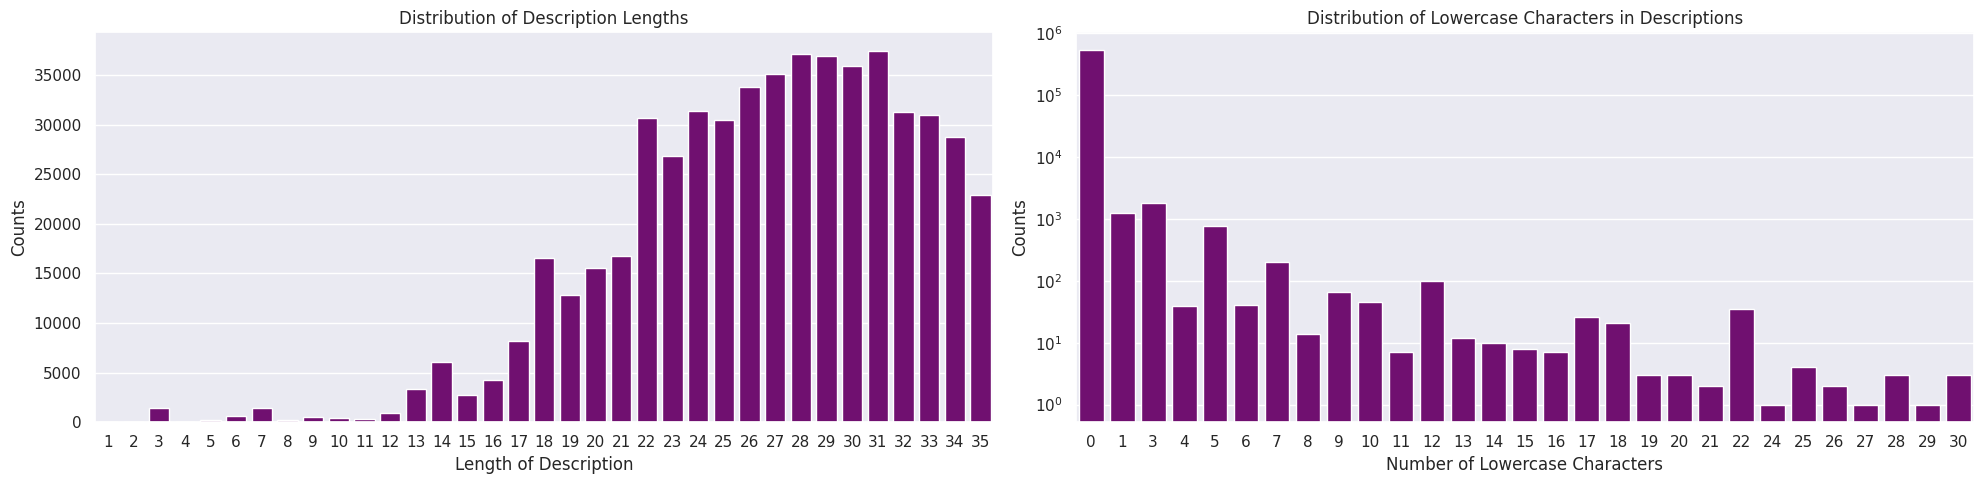

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# Count plot for description lengths
sns.countplot(x=data.DescriptionLength, ax=ax[0], color="Purple")
ax[0].set_xlabel("Length of Description")
ax[0].set_ylabel("Counts")
ax[0].set_title("Distribution of Description Lengths")

# Count plot for number of lowercase characters in descriptions
sns.countplot(x=data.LowCharsInDescription, ax=ax[1], color="Purple")
ax[1].set_xlabel("Number of Lowercase Characters")
ax[1].set_ylabel("Counts")
ax[1].set_title("Distribution of Lowercase Characters in Descriptions")
ax[1].set_yscale("log")  # Apply log scale to y-axis for better visualization

# Display the plots
plt.tight_layout()
plt.show()


Oh, great! **Almost all descriptions do not have a lowercase chars, but we have found exceptional cases!**

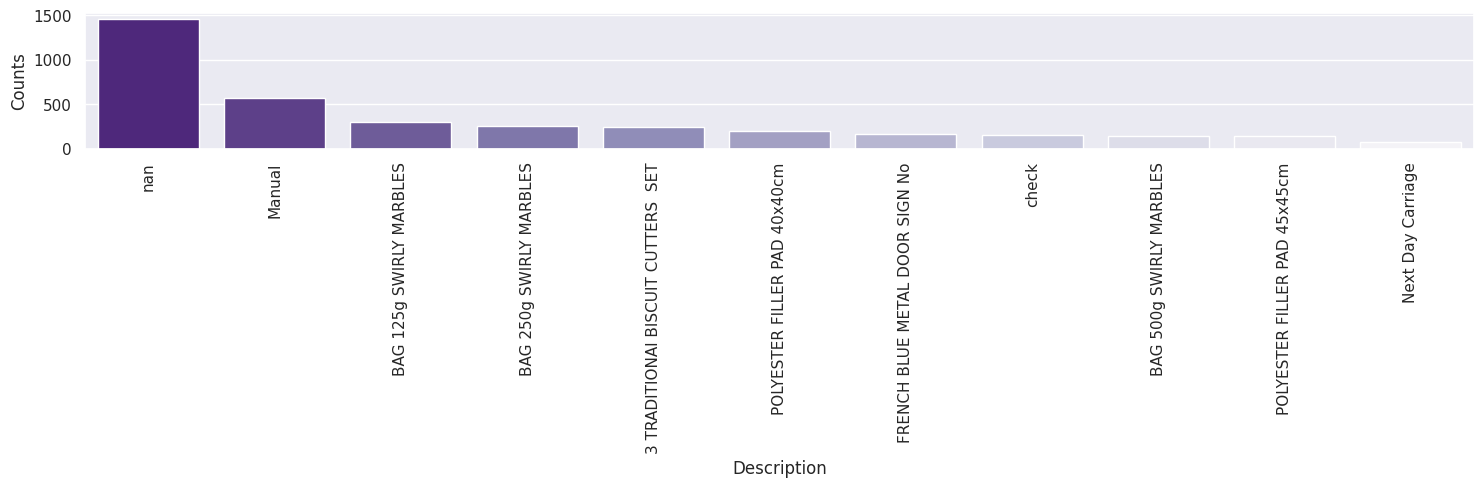

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter descriptions with more than 0 lowercase characters
lowchar_counts = data.loc[data.LowCharsInDescription > 0, 'Description'].value_counts()

# Select the top 11 descriptions
top_11_lowchar_counts = lowchar_counts.head(11)

# Create the bar plot
plt.figure(figsize=(15, 5))  # Adjusted figure size for better readability
sns.barplot(x=top_11_lowchar_counts.index, y=top_11_lowchar_counts.values, palette="Purples_r")

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Add labels and title
plt.xlabel("Description")
plt.ylabel("Counts")

# Display the plot
plt.tight_layout()
plt.show()


**Next day carriage and high resolution image are strange!** Let's compute the fraction of lower with respect to uppercase letters:

In [19]:
def count_upper_chars(l):
    return sum(1 for c in l if c.isupper())

data["UpCharsInDescription"] = data.Description.apply(lambda l: count_upper_chars(l))

In [20]:
data.UpCharsInDescription.describe()

,UpCharsInDescription
count,541909.000000
mean,22.520628
std,4.747132
min,0.000000
25%,20.000000
50%,23.000000
75%,26.000000
max,32.000000


In [21]:
data.loc[data.UpCharsInDescription <=5].Description.value_counts()

,count
Description,
nan,1454
Manual,572
check,159
Next Day Carriage,80
Discount,77
...,...
sold as set/6 by dotcom,1
damages/dotcom?,1
on cargo order,1


It's strange that they differ from the others. Let's drop them:

In [22]:
data = data.loc[data.UpCharsInDescription > 5].copy()

And what about the descriptions with a length below 14?

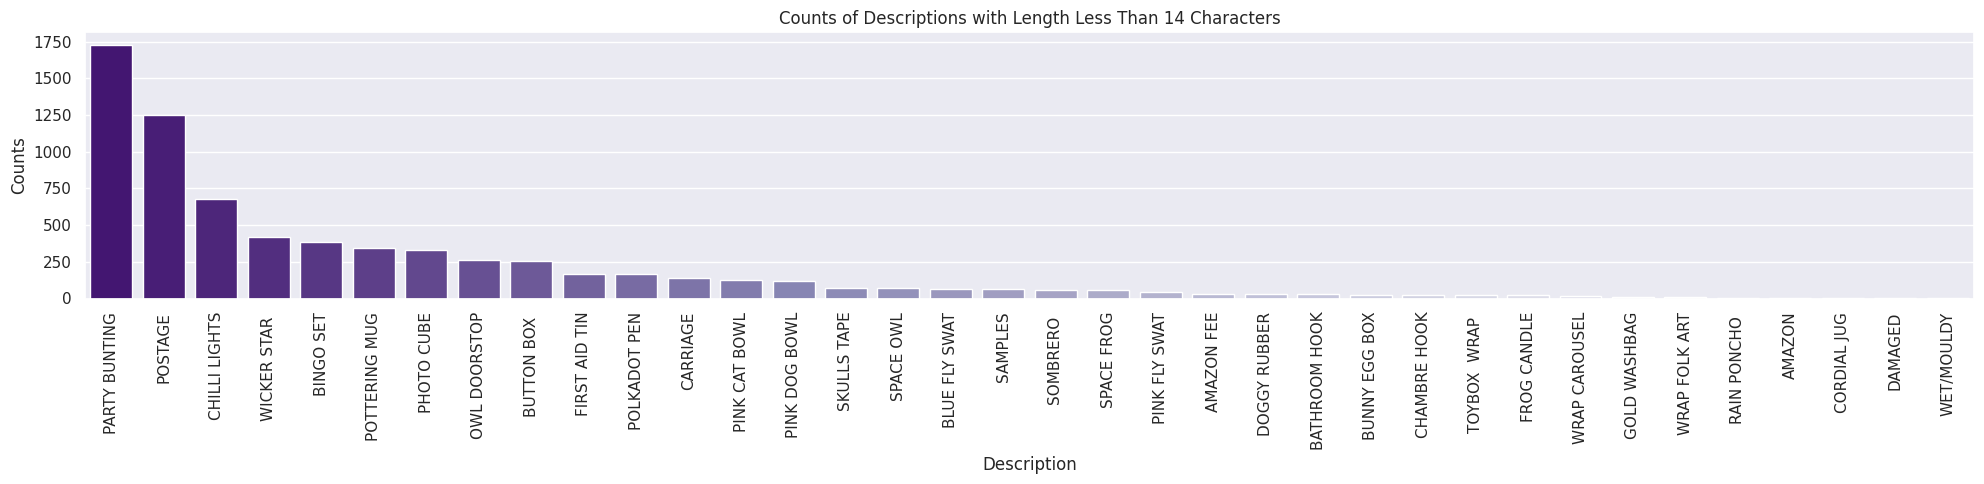

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter descriptions with length less than 14 characters
dlength_counts = data.loc[data.DescriptionLength < 14, 'Description'].value_counts()

# Create the bar plot
plt.figure(figsize=(20, 5))  # Adjust the size for better readability
sns.barplot(x=dlength_counts.index, y=dlength_counts.values, palette="Purples_r")

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Add labels and title
plt.xlabel("Description")
plt.ylabel("Counts")
plt.title("Counts of Descriptions with Length Less Than 14 Characters")

# Display the plot
plt.tight_layout()
plt.show()
